#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Advanced Machine Learning Methods**
###**Tecnológico de Monterrey**
###**Prof José Antonio Cantoral Ceballos**


###**Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset**

#### **Team 56:**

* Daniel Ruiz Gutiérrez A01100513
* José Manuel GarcÍa Ogarrio A01795147
* Miriam Bönsch A01330346
* Raul Eduardo Gomez Godinez A01795214
* Renzo Zagni A01795457
* Roger Alexei Urrutia ParKer A01362405


# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import math

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')
DIR = "/content/drive/MyDrive/MNA/Advanced ML/Module 1. Introduction to Deep Learning and Fully Connected Networks/Actividad 1 (Equipo)/asl_data/"
os.chdir(DIR)

Mounted at /content/drive


In [3]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
DATA_PATH = '/content/drive/MyDrive/MNA/Advanced ML/Module 1. Introduction to Deep Learning and Fully Connected Networks/Actividad 1 (Equipo)/asl_data/'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [4]:
train_df.shape

(27455, 785)

In [5]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
#
# Calculate the % split between test and validation data and analise labels
tot = train_df.shape[0] + valid_df.shape[0]
perc_valid = valid_df.shape[0]/tot
perc_train = train_df.shape[0] /tot
print(f'% Training: {perc_train}, % Validation: {perc_valid}')
print(f"Labels: {train_df['label'].sort_values().unique()} \nNo of Labels: {len(train_df['label'].unique())}")

% Training: 0.7928783896959021, % Validation: 0.20712161030409795
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] 
No of Labels: 24


### Importar Images

In [7]:
#
# Separate x and y data in separate datasets
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [8]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    """
    Splits the validation data into two parts: validation and test sets.

    Args:
        x (np.array): The dataset features.
        y (np.array): The dataset labels.
        pct (float): The percentage to use for the test set.
        shuffle (bool): Whether to shuffle the data before splitting.

    Returns:
        x_val (np.array): Validation set features.
        y_val (np.array): Validation set labels.
        x_test (np.array): Test set features.
        y_test (np.array): Test set labels.
    """
    if shuffle:
      #
      # Find the total number of rows in the training set and create a list 0 to n
      idx = list(range(len(x)))
      #
      # Shuffles the list
      np.random.shuffle(idx)
      #
      # Use the shuffled indexes to shuffle the data in the datasets
      x = x[idx]
      y = y[idx]
    assert pct > 0 and pct < 1, 'Error in percentage split'
    #
    # If pct != 0.5 the amount will apply to the test dataset while the
    # difference ex: pct - 1 will apply to the validation dataset
    thresh = math.floor(len(x) * pct)
    x_test = x[:thresh]
    x_val = x[thresh:]
    y_test = y[:thresh]
    y_val = y[thresh:]

    return x_val, y_val, x_test, y_test

In [9]:
#
# Create validation and test partitioning the original test dataset by 50%
# and shuffle the data
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val, pct=0.5 , shuffle=True)

In [10]:
#
# Validate shapes
print(f'x_train shape: {x_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')

x_train shape: (27455, 784)
y_train.shape: (27455,)
x_test shape: (3586, 784)
y_test.shape: (3586,)
x_val shape: (3586, 784)
y_val.shape: (3586,)


In [11]:
# ### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))
print(alphabet)

24
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


### Normalise

In [12]:
def standarization(xtrain, xtest, x_validation):
    '''
    Standardizes the input data (train, test, and validation) using the mean and standard deviation of the training data to avoid data leakage.

    Parameters:
        xtrain       : The training dataset
        xtest        : The test dataset
        x_validation : The validation dataset .

    Ret:
        xtrain_norm : The standardized training dataset.
        xtest_norm  : The standardized test dataset.
        xval_norm   : The standardized validation dataset.
    '''
    # Define mean and standard deviation using training data to avoid data leakage
    x_mean = xtrain.mean()
    x_std  = xtrain.std()

    # Standardization of train, test, and validation datasets
    xtrain_norm = (xtrain - x_mean)/x_std
    xtest_norm  = (xtest - x_mean)/x_std
    xval_norm   = (x_validation - x_mean)/x_std

    return xtrain_norm, xtest_norm, xval_norm


x_train, x_test, x_val = standarization(x_train, x_test, x_val)

In [13]:
print(f'Training Mean: {x_train.mean():.2f}\tTraining Std Dev: {x_train.std():.2f}')
print(f'Test Mean: {x_test.mean():.2f} \tTest Std Dev: {x_test.std():.2f}')
print(f'Validation Mean: {x_val.mean():.2f} \tValidation Std Dev: {x_val.std():.2f}')

Training Mean: 0.00	Training Std Dev: 1.00
Test Mean: 0.03 	Test Std Dev: 1.00
Validation Mean: 0.03 	Validation Std Dev: 1.01


### Graficar muestras

In [14]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('bone'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa la letra: e


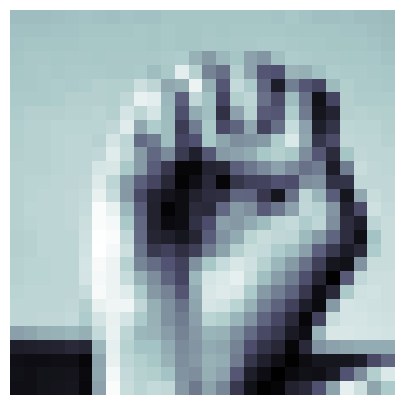

In [15]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa la letra: {alphabet[y_test[rnd_idx]]}')
plot_number(x_test[rnd_idx].reshape(28, 28))

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

In [16]:
class np_tensor(np.ndarray):
  """
  A custom tensor class that extends numpy's ndarray to store gradients.
  """
  pass

#### Mini batches

In [17]:
def minibatch(X,y, batch_size=32):

  """
  A generator that yields minibatches of data.

  Args:
      X (np.array): The dataset features.
      y (np.array): The dataset labels.
      batch_size (int): The size of each minibatch.

  Yields:
      (np.array, np.array): A minibatch of data (features and labels).
  """
  total_rows = X.shape[0]
  #
  # Randomize the order of the inputs (shuffle)
  idxs = np.arange(total_rows)
  np.random.shuffle(idxs)
  for i in range( 0, total_rows, batch_size):
    yield X[i: i + batch_size ], y[i: i + batch_size]


## Nuestra clase Linear, ReLU y Sequential

###  Clase Linear

In [18]:
class Linear:
  """
  A fully connected linear layer that performs a linear transformation.

  Attributes:
    W (np_tensor): The weight matrix.
    b (np_tensor): The bias vector.
  """

  def __init__(self, input_size, neurons):
    """
    Initializes the linear layer with randomly generated weights and biases.

    Args:
      input_size (int): The number of input features.
      neurons (int): The number of neurons (outputs).
    """
    self.W = (np.random.randn(neurons, input_size)/np.sqrt(input_size/2)).view(np_tensor)
    self.b = np.zeros((neurons, 1)).view(np_tensor)

  def __call__(self, X):
    """
    Performs a forward pass of the linear layer.

    Args:
      X (np_tensor): The input data.

    Returns:
      Z (np_tensor): The result of the linear transformation.
    """

    Z = np.dot(self.W, X) + self.b
    return Z

  def backward(self, X, Z):
    """
    Backpropagates the gradient through the linear layer.

    Args:
      Z (np_tensor): The output of the layer (forward pass).
      X (np_tensor): The input to the layer.
    """
    X.grad = np.dot(self.W.T, Z.grad)
    self.W.grad = np.dot(Z.grad,X.T)
    self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)



### Clase ReLU

In [19]:
class ReLU():
  """
  Implements the ReLU (Rectified Linear Unit) activation function and its gradient for backpropagation.

  ReLU is defined as:
  ReLU(x) = max(0, x)

  Attributes:
    None
  """

  def __call__(self, input):
    """
    Applies the ReLU activation function on the input.

    Args:
      input (np_tensor): The input array on which to apply ReLU.

    Returns:
      np_tensor: The result of applying ReLU, where all negative values are set to zero.
    """
    return np.maximum(0, input)

  def backward(self, Z, A):
    """
    Backpropagates the gradient through the ReLU activation function.

    Args:
      Z (np_tensor): The input to the ReLU during the forward pass.
      A (np_tensor): The output from the next layer in the network (during backward pass).

    Modifies:
      Z.grad (np_tensor): The gradient of the input Z, where all negative entries in Z
                          during the forward pass have zero gradient.
    """
    Z.grad = A.grad.copy()
    Z.grad[Z <= 0] = 0


### Clase Sequential

In [20]:
class Sequential():

  """
  A container for stacking layers in a neural network.

  Attributes:
    layers (list): A list of layers to stack.
    layer_out (dict): A dictionary to store the output of each layer.
  """
  def __init__(self, layers):
    """
    Initializes the neural network with the provided layers.

    Args:
      layers (list): A list of layers to stack in the network.
    """
    self.layers = layers
    self.layer_out = {} # Keep track out outputs per layer

  def __call__(self, X):
    """
    Performs the forward pass for the entire network.

    Args:
      X (np_tensor): The input data.

    Returns:
      np_tensor: The output of the final layer.
    """
    self.x = X
    self.layer_out['layer0'] = self.x

    for i, layer in enumerate(self.layers, 1):
      self.x = layer(self.x)
      self.layer_out['layer' + str(i) ] = self.x
    return self.x

  def backward(self):
    """
      Performs backpropagation through the entire network.
      Loops from output in reverse . Note we have one more output than layers hence i + 1
      Example: For layer 3 layer_out params will be layer_out['l3'] and layer_out['l4']
               For layer 0 layer_out['l0'] and layer_out['l1']
    """
    for i in reversed(range(len(self.layers))):
      self.layers[i].backward(self.layer_out['layer' + str(i)], self.layer_out['layer' + str(i + 1)])

  def update(self , learning_rate=1e3):
    """
    Updates the weights of all layers using the calculated gradients.

    Args:
      learning_rate (float): The learning rate for gradient descent.
    """
    for layer in self.layers:
      if isinstance(layer, Linear):
        layer.W = layer.W - learning_rate * layer.W.grad
        layer.b = layer.b - learning_rate * layer.b.grad

  def predict(self, X):
    """
    Generates predictions from the network.

    Args:
      X (np.array): The input data.

    Returns:
      int: The predicted class labels.
    """
    r = np.argmax(self.__call__(X))
    return np.argmax(self.__call__(X))

### Cost Function

In [21]:
def softmaxXEntropy(x, y):
  """
  Computes the softmax activation and cross-entropy loss.

  Args:
    x (np_tensor): The input scores (logits).
    y (np.array): The true labels.

  Returns:
    (np_tensor, float): The predicted probabilities and the cost (loss).
  """
  batch_size = x.shape[1]
  exp_scores = np.exp(x)
  probs = exp_scores / exp_scores.sum(axis = 0)
  preds = probs.copy()
  y_hat = probs[y.squeeze(), np.arange(batch_size)]
  cost = np.sum(-np.log(y_hat)) / batch_size
  probs[y.squeeze(), np.arange(batch_size)] -= 1
  x.grad = probs.copy()
  return preds, cost

### Loop de entrenamiento

### Create your model and train it

In [22]:
def train(model, epochs, batch_size=32, learning_rate = 1e-3):
  """
  Trains the model using minibatch & gradient descent.

  Args:
    model (Sequential): The neural network model.
    epochs (int): The number of epochs to train for.
    batch_size (int): The size of each minibatch.
    learning_rate (float): The learning rate for gradient descent.
  """
  for epoch in range(epochs):
      for i, (x, y) in enumerate(minibatch(x_train, y_train, batch_size)):
          scores = model(x.T.view(np_tensor))
          _, cost = softmaxXEntropy(scores, y)
          model.backward()
          model.update(learning_rate)
      accur = accuracy(x_val, y_val, model, batch_size)
      print(f'epoch: {epoch + 1} -> cost: {cost}, accuracy: {accur}')


In [23]:
def accuracy(x, y, model, batch_size=32):
  """
  Computes the accuracy of the model.

  Args:
      x (np.array): The dataset features.
      y (np.array): The true labels.
      model (Sequential): The neural network model.
      batch_size (int): The size of each minibatch
  """
  correct = 0
  total = 0
  for i, (x, y) in enumerate(minibatch(x, y, batch_size)):
      y_hat = model(x.T.view(np_tensor))
      correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
      total += y_hat.shape[1]
  return correct/total

In [24]:
#
# Instatiante the model class. Set the hyperparmeters for model object and train method
model = Sequential([Linear(784, 300), ReLU(), Linear(300, 300), ReLU(), Linear(300, 24)])
batch_size = 64
learning_rate = 4e-3
epochs = 40

In [25]:
train(model, epochs, batch_size, learning_rate)

epoch: 1 -> cost: 0.005707940075152039, accuracy: 0.7939208031232571
epoch: 2 -> cost: 0.0020424444940623184, accuracy: 0.8020078081427775
epoch: 3 -> cost: 0.0012042950717861113, accuracy: 0.8078639152258784
epoch: 4 -> cost: 0.0008456497151411318, accuracy: 0.8092582264361405
epoch: 5 -> cost: 0.0006450095345350928, accuracy: 0.8098159509202454
epoch: 6 -> cost: 0.0005182447528464323, accuracy: 0.8092582264361405
epoch: 7 -> cost: 0.00043166789073421387, accuracy: 0.8098159509202454
epoch: 8 -> cost: 0.0003692453109280718, accuracy: 0.8098159509202454
epoch: 9 -> cost: 0.00032171967953425806, accuracy: 0.809537088678193
epoch: 10 -> cost: 0.0002844388462079387, accuracy: 0.8092582264361405
epoch: 11 -> cost: 0.0002544674113532397, accuracy: 0.8089793641940881
epoch: 12 -> cost: 0.00022993398808587745, accuracy: 0.8078639152258784
epoch: 13 -> cost: 0.00020961207338531955, accuracy: 0.8081427774679308
epoch: 14 -> cost: 0.0001925531559372651, accuracy: 0.8089793641940881
epoch: 15 -> 

### Test your model on Random data from your test set

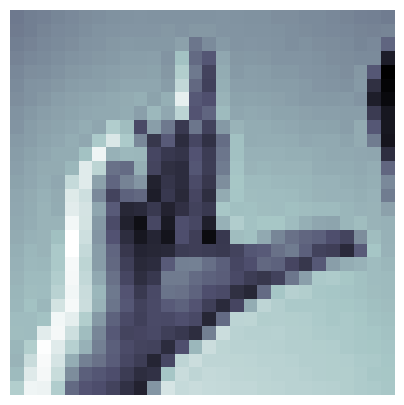

el valor predicho es: l el valor real es: l


In [26]:
#
# Validate our model

idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {alphabet[pred]} el valor real es: {alphabet[y_test[idx]]}')

Conclusion:

As part of this interesting project, we deepened our understanding of the steps involved in building and training neural networks. This knowledge clarified the various components of a neural network and highlighted the importance of the mathematics underpinning each of them. Understanding each stage of the training process is essential, as these stages form the foundation for deep learning (DL) and more advanced machine learning (ML) algorithms. By understanding how neurons function and learn from data, we are better equipped to tackle complex problems and innovate across various industries.

In this project, we used the Kaggle ASL dataset to train a multi-layer perceptron (MLP) to identify low-resolution hand images representing letters. We divided the dataset into training, validation, and test sets; normalized the data; implemented a function to partition the data into mini-batches; and wrote code for the activation functions, including the `Linear` class, `ReLU`, and `Sequential` class. We then calculated the cost function and built and trained the model.

During the training phase, we experimented with different sets of hyperparameters, such as increasing the number of neurons per layer, adding hidden layers (from 1 to 3), and adjusting the learning rate.

Interestingly, we found that the model performed best with a relatively simple configuration: a single hidden layer with 300 neurons in the last two layers. This result was initially counterintuitive, as we expected better accuracy with more neurons and additional hidden layers. However, we concluded that the added complexity led to overfitting.

It is also worth noticing that the maximum accuracy was achieved before the final epoch, regardless of the total number of epochs. At this point, the cost had become extremely low, and further reductions after each epoch were minimal. This allowed us to optimize the number of epochs and reduce resource utilization.

In conclusion, deep learning models are powerful tools for image classification, but their success depends on careful tuning of various factors. These include the quality and structure of the data, the size of the batches in which the data is processed, the number of epochs used to refine the learning process, and the learning rate, which determines how quickly or gradually the model adjusts its weights.

